In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [2]:
np.random.seed(42) 

In [3]:
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['species'] = iris.target
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
X = iris.data
y = iris.target

# data splitting
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test  = scaler.transform(X_test)      

In [6]:
# number of classes (iris has 3 species: 0,1,2)
num_classes = len(np.unique(y))
# X has shape (num_samples, num_features)
num_samples, num_features = X.shape
input_size = num_features

In [7]:
# one-hot in data processing
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

In [8]:
# Activation functions
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)
    
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)
    
def softmax(z):
    # stability trick
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [9]:
class NeuralNet:
  
    def __init__(self, sizes, learning_rate=0.01, keep_prob=1.0):
        
        self.lr = learning_rate
        self.keep_prob = keep_prob
        self.W = []
        self.b = []

        # # Simple random initialization 
        # for i in range(len(sizes) - 1):
        #     self.W.append(np.random.randn(sizes[i], sizes[i+1]) * 0.01)
        #     self.b.append(np.zeros((1, sizes[i+1])))


        # He initialization for ReLU
        for i in range(len(sizes) - 1):
            fan_in = sizes[i]
            self.W.append(np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2.0 / fan_in))
            self.b.append(np.zeros((1, sizes[i+1])))

            
    
    # Forward pass
    def forward(self, X, training=True):
        
        A = X
        
        # store (Z, A) for each layer
        self.cache = []
        self.training = training 

        for i in range(len(self.W)):

            A_prev = A
            Z = A_prev @ self.W[i] + self.b[i]

            # hidden layers: ReLU
            if i < len(self.W) - 1:
                A = relu(Z)


                # inverted dropout (training only)
                if training and self.keep_prob < 1.0:                       
                    mask = (np.random.rand(*A.shape) < self.keep_prob).astype(float) 
                    # scale activation
                    A = (A * mask) / self.keep_prob                        
                else:
                    mask = None 
                    

                
            # last layer: Softmax
            else:
                A = softmax(Z)
                # output layer has no dropout
                mask = None   

            self.cache.append((A_prev, Z, A, mask)) 

        return A

        
    # Loss function
    def compute_loss(self, y_pred, y_true):
    
        # number of samples
        m = y_true.shape[0]

        # add small epsilon to avoid log(0)
        eps = 1e-12
        
        loss = -np.sum(y_true * np.log(y_pred + eps)) / m
        return loss
        
        
    # Backward pass
    def backward(self, y_true):

        # number of samples
        m = y_true.shape[0]

        # last layer index
        L = len(self.W) - 1  

        # Output layer
        _, _, AL, _ = self.cache[L]
        dZ = (AL - y_true) / m

        for i in reversed(range(len(self.W))):

            # Current layer cache
            A_prev, _, _, _ = self.cache[i]

            dW = A_prev.T @ dZ
            db = np.sum(dZ, axis=0, keepdims=True)

            # save old W before updating
            W_i = self.W[i].copy()
            
            # compute dZ for previous layer using OLD W
            if i > 0:
                dA_prev = dZ @ W_i.T
                
                # Z_prev for ReLU derivative, mask_prev for dropout backward
                _, Z_prev, _, mask_prev = self.cache[i-1] 

                # inverted dropout backward (training only)
                if mask_prev is not None:   
                    # scale gradient
                    dA_prev = (dA_prev * mask_prev) / self.keep_prob           
                    
                dZ = dA_prev * relu_derivative(Z_prev)
            
            # update after using W_i
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    
    # Prediction
    def predict(self, X):
        probs = self.forward(X, training=False) 
        return np.argmax(probs, axis=1)

In [10]:
hidden_sizes = [10, 6] 
learning_rate = 0.05
num_epochs = 1000




# define architecture by a list
sizes = [input_size] + hidden_sizes + [num_classes]
# initialize neural network
nn = NeuralNet(sizes=sizes, learning_rate=learning_rate, keep_prob=0.8)


# history for plots
epochs_record = []
train_losses = []
test_losses = []
train_accs = []
test_accs = []




for epoch in range(num_epochs):

    # forward on train
    y_pred_train = nn.forward(X_train, training=True) 

    # train loss
    train_loss = nn.compute_loss(y_pred_train, y_train_oh)

    # update parameters
    nn.backward(y_train_oh)

    if (epoch + 1) % 100 == 0:

        # train acc
        train_preds = np.argmax(y_pred_train, axis=1)
        train_acc = np.mean(train_preds == y_train)

        # forward on test
        y_pred_test = nn.forward(X_test,  training=False) 

        # test loss
        test_loss = nn.compute_loss(y_pred_test, y_test_oh) 

        # test acc
        test_preds = np.argmax(y_pred_test, axis=1)           
        test_acc = np.mean(test_preds == y_test)  


        # record history                              
        epochs_record.append(epoch + 1)                   
        train_losses.append(train_loss)                   
        test_losses.append(test_loss)                     
        train_accs.append(train_acc)                      
        test_accs.append(test_acc)                       
        
        print(f"Epoch {epoch+1:4d} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

Epoch  100 | Train loss: 0.5255 | Test loss: 0.4256 | Train acc: 0.7250 | Test acc: 0.9000
Epoch  200 | Train loss: 0.4479 | Test loss: 0.3103 | Train acc: 0.8000 | Test acc: 0.9667
Epoch  300 | Train loss: 0.3892 | Test loss: 0.2462 | Train acc: 0.8333 | Test acc: 1.0000
Epoch  400 | Train loss: 0.3908 | Test loss: 0.1998 | Train acc: 0.8333 | Test acc: 1.0000
Epoch  500 | Train loss: 0.3391 | Test loss: 0.1679 | Train acc: 0.8750 | Test acc: 1.0000
Epoch  600 | Train loss: 0.3200 | Test loss: 0.1484 | Train acc: 0.8667 | Test acc: 1.0000
Epoch  700 | Train loss: 0.2901 | Test loss: 0.1291 | Train acc: 0.8750 | Test acc: 1.0000
Epoch  800 | Train loss: 0.3222 | Test loss: 0.1173 | Train acc: 0.8833 | Test acc: 1.0000
Epoch  900 | Train loss: 0.2957 | Test loss: 0.1045 | Train acc: 0.9000 | Test acc: 1.0000
Epoch 1000 | Train loss: 0.2504 | Test loss: 0.0966 | Train acc: 0.9000 | Test acc: 1.0000


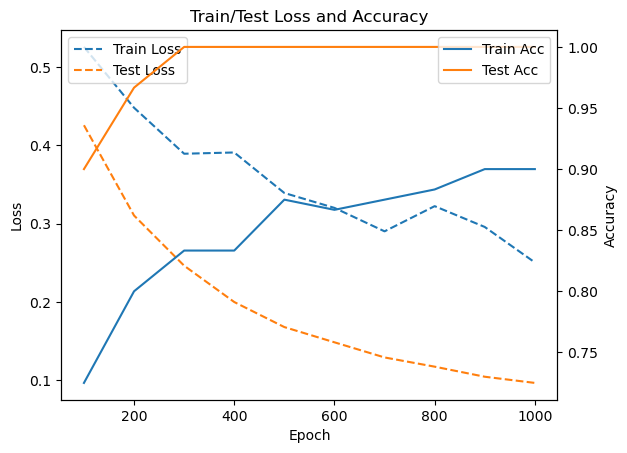

In [11]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()   # <<< REQUIRED

# Loss on left y-axis (dashed)
ax1.plot(
    epochs_record, train_losses,
    label="Train Loss", linestyle="--", color="tab:blue"
)
ax1.plot(
    epochs_record, test_losses,
    label="Test Loss", linestyle="--", color="tab:orange"
)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

# Accuracy on right y-axis (solid)
ax2 = ax1.twinx()
ax2.plot(
    epochs_record, train_accs,
    label="Train Acc", color="tab:blue"
)
ax2.plot(
    epochs_record, test_accs,
    label="Test Acc", color="tab:orange"
)

ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")

plt.title("Train/Test Loss and Accuracy")
plt.show()
